# TELECOM CHURN CASE STUDY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/telecom_churn_data.zip

Archive:  /content/drive/MyDrive/telecom_churn_data.zip
  inflating: telecom_churn_data.csv  


![](https://krishastudio.com/wp-content/uploads/2021/06/Main-1.gif)

###  *Business Objective*
To predict churn for the high value customers churn(Usage- Based Churn) in the last (i.e the ninth /September) month using the data from the first three months(June, July, and August).

### *Goals*
- Perform EDA
- Filter High value customers.
- Build Models : To predict whether a high value customer will churn or not, in near future(i.e churn phase- 9th month)
- Build Model  : To identify important variables that are strong predictors of churn.
- Strategies to manage customer churn.

In [ ]:
#Importing required libraries

import numpy as np
import pandas as pd
import time
from numpy.random import randn
from itertools    import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn import metrics

#Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Read the Dataset.
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


# EDA

In [ ]:
#Data type and Non-Null count of varaibles present in the data set.
telecom.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mobile_number             99999 non-null  int64  
 1   circle_id                 99999 non-null  int64  
 2   loc_og_t2o_mou            98981 non-null  float64
 3   std_og_t2o_mou            98981 non-null  float64
 4   loc_ic_t2o_mou            98981 non-null  float64
 5   last_date_of_month_6      99999 non-null  object 
 6   last_date_of_month_7      99398 non-null  object 
 7   last_date_of_month_8      98899 non-null  object 
 8   last_date_of_month_9      98340 non-null  object 
 9   arpu_6                    99999 non-null  float64
 10  arpu_7                    99999 non-null  float64
 11  arpu_8                    99999 non-null  float64
 12  arpu_9                    99999 non-null  float64
 13  onnet_mou_6               96062 non-null  float64
 14  onnet

In [ ]:
#Observation : All the date columns in the dataset have a datatype of an object.
#Convert date columns in the dataset from Object to Date
for i in telecom.select_dtypes('object'):
    telecom[i] = pd.to_datetime(telecom[i])

#Print all the columns that contains datetime values
telecom.select_dtypes('datetime64[ns]').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   last_date_of_month_6      99999 non-null  datetime64[ns]
 1   last_date_of_month_7      99398 non-null  datetime64[ns]
 2   last_date_of_month_8      98899 non-null  datetime64[ns]
 3   last_date_of_month_9      98340 non-null  datetime64[ns]
 4   date_of_last_rech_6       98392 non-null  datetime64[ns]
 5   date_of_last_rech_7       98232 non-null  datetime64[ns]
 6   date_of_last_rech_8       96377 non-null  datetime64[ns]
 7   date_of_last_rech_9       95239 non-null  datetime64[ns]
 8   date_of_last_rech_data_6  25153 non-null  datetime64[ns]
 9   date_of_last_rech_data_7  25571 non-null  datetime64[ns]
 10  date_of_last_rech_data_8  26339 non-null  datetime64[ns]
 11  date_of_last_rech_data_9  25922 non-null  datetime64[ns]
dtypes: datetime64[ns](

In [ ]:
#Null values percentage count
#pd.set_option('display.max_rows', None)
nullCount = pd.DataFrame(round(telecom.isnull().sum()[telecom.isnull().sum()>1]/telecom.shape[0] * 100,2),columns=['NullPercentage'])
nullCount.sort_values(by="NullPercentage",ascending=False)

,NullPercentage
count_rech_2g_6,74.85
max_rech_data_6,74.85
arpu_3g_6,74.85
av_rech_amt_data_6,74.85
count_rech_3g_6,74.85
...,...
last_date_of_month_8,1.10
std_og_t2o_mou,1.02
loc_ic_t2o_mou,1.02
loc_og_t2o_mou,1.02


In [ ]:
#Drop columns which have more than 70% Null values
telecom = telecom.dropna(thresh=telecom.shape[0]*0.7,how='all',axis=1)
telecom.shape

(99999, 186)

In [ ]:
#Null values percentage after droping the variables
nullCount = pd.DataFrame(round(telecom.isnull().sum()[telecom.isnull().sum()>1]/telecom.shape[0] * 100,2),columns=['NullPercentage'])
nullCount.sort_values(by="NullPercentage",ascending=False)

,NullPercentage
loc_og_t2f_mou_9,7.75
loc_og_t2t_mou_9,7.75
std_ic_t2o_mou_9,7.75
loc_og_mou_9,7.75
roam_og_mou_9,7.75
...,...
last_date_of_month_8,1.10
std_og_t2o_mou,1.02
loc_ic_t2o_mou,1.02
loc_og_t2o_mou,1.02


In [ ]:
#Fill all the Null values with 0
telecom = telecom.fillna(0)

# Derived Metrics

In [ ]:
#Create a new metric arpu_diff - Average revenue per user difference between action phase(8) and mean of good phase(6,7)
telecom['arpu_diff'] = telecom['arpu_8'] - (telecom['arpu_6']+telecom['arpu_7'])/2

In [ ]:
#Create a new metric AON_Y  - Approx number of years the customer is using the operator T network
bins = [0, 1, 2, 4, 6, 8, 12]
labels = ["<1 Year","1-2 Year","2-4 Year","4-6 Year","6-8 Year",">8 Year"]
telecom['AON_Y'] = pd.cut((telecom['aon']/365),bins=bins, labels=labels).astype('object')

In [ ]:
#Create a new metric TotalRech-2G - Total number of recharge for 2G Data
telecom['TotalRech-2G'] = 0
for i in range(6,9):
    telecom['TotalRech-2G'] += telecom['monthly_2g_'+str(i)]+telecom['sachet_2g_'+str(i)]

In [ ]:
#Create a new metric TotalRech-3G - Total number of recharge for 3G Data
telecom['TotalRech-3G'] = 0
for i in range(6,9):
    telecom['TotalRech-3G'] += telecom['monthly_3g_'+str(i)]+telecom['sachet_3g_'+str(i)]

In [ ]:
#Create a new metric TotalRech_2G-3G - Total number of recharge for Internet(2G+3G)
telecom['TotalRech_2G-3G'] = telecom['TotalRech-2G'] + telecom['TotalRech-3G']

In [ ]:
#Create a new metric to identify which whether user using Internet or not.
telecom['InternetUser'] = np.where(telecom['TotalRech-2G'] + telecom['TotalRech-3G'] > 0 , 1 , 0)

In [ ]:
#Create a new metric TotalRech-Call - Total number of recharge.
telecom['TotalRech-Call'] = 0
for i in range(6,9):
    telecom['TotalRech-Call'] += telecom['total_rech_num_'+str(i)]

In [ ]:
#Create a new metric TotalRech-Call - Total recharge amount for call.
telecom['TotalRech-Call_Amnt'] = 0
for i in range(6,9):
    telecom['TotalRech-Call_Amnt'] += telecom['total_rech_amt_'+str(i)]

In [ ]:
#Create a new metric that tells the type of customer e.g only used for calling, Using only Internet,
#using both Calling and Internet, and None (Uses neither calling nor Internet)

#uType function that categorise the User based on services used
def uType(row):
    if (row['TotalRech_2G-3G'] ==0 and row['TotalRech-Call'] > 0):
        userType= "Calling Service Only"
    elif (row['TotalRech_2G-3G'] >0 and row['TotalRech-Call'] == 0):
         userType= "Internet Service Only"
    elif (row['TotalRech_2G-3G'] >0 and row['TotalRech-Call']> 0):
        userType = "Both Call & Internet"
    else:
        userType = "None"
    return userType

telecom['UserType']= telecom.apply(uType,axis=1)

In [ ]:
#Create a new metric that tells total internet used by the user in three month
telecom['TotalDataUsed'] = 0
for i in range(6,9):
    telecom['TotalDataUsed'] += telecom['vol_2g_mb_'+str(i)] + telecom['vol_3g_mb_'+str(i)]

telecom['TotalDataUsed'] = round((telecom['TotalDataUsed']),2)

In [ ]:
#Create a new metric that tells total call time of a user in three month
telecom['TotalCallTime'] = 0
for i in range(6,9):
    telecom['TotalCallTime'] += telecom['total_ic_mou_'+str(i)] + telecom['total_og_mou_'+str(i)]

telecom['TotalCallTime'] = round(telecom['TotalCallTime']/60,2)  #Convert to Hour

## Filter High Value Customers

In [ ]:
#Filter High value customers.
#threshold : Customer who have recharged more than and equal to 7oth percentile of the average recharge amount in the first two months(Good Phase)
threshold = ((telecom['total_rech_amt_6']+telecom['total_rech_amt_7'])/2)

In [ ]:
telecomfilter = telecom[(telecom['total_rech_amt_6']+telecom['total_rech_amt_7'])/2 >=threshold.quantile(q=0.7)]

#Shape of data frame after customer filter
telecomfilter.shape

(30011, 197)

## Tag Churners

In [ ]:
#Tag the churned customer (Churn=1, else=0) using total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,and vol_3g_mb_9
telecomfilter['Churn'] = np.where(telecomfilter['total_ic_mou_9']+telecomfilter['total_og_mou_9']+telecomfilter['vol_2g_mb_9']
                                 + telecomfilter['vol_3g_mb_9'] == 0, 1 , 0) 

In [ ]:
#Count number of churn customers.
telecomfilter['Churn'].value_counts()

0    27418
1     2593
Name: Churn, dtype: int64

In [ ]:
#Remove all the attributes corresponding to the Churn Phase(all the attributes having "_9" in their names).
telecomfilter = telecomfilter[telecomfilter.columns.drop(list(telecomfilter.filter(regex='_9')))]
telecomfilter = telecomfilter.drop(columns='sep_vbc_3g',axis=1)

#Shape of dataframe after dropping the column.
telecomfilter.shape

(30011, 153)

In [ ]:
telecomfilter.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,...,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_diff,AON_Y,TotalRech-2G,TotalRech-3G,TotalRech_2G-3G,InternetUser,TotalRech-Call,TotalRech-Call_Amnt,UserType,TotalDataUsed,TotalCallTime,Churn
7,7000701601,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,...,2014-06-27 00:00:00,2014-07-25 00:00:00,2014-08-26 00:00:00,0,0,779,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1961.9650,2-4 Year,0,0,0,0,17,6008,Calling Service Only,0.00,51.00,1
8,7001524846,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,...,2014-06-25 00:00:00,2014-07-31 00:00:00,2014-08-30 00:00:00,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,-298.1100,<1 Year,5,0,5,1,54,1158,Both Call & Internet,1118.92,21.01,0
13,7002191713,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,...,2014-06-20 00:00:00,2014-07-22 00:00:00,2014-08-30 00:00:00,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,244.0015,6-8 Year,3,0,3,1,21,1477,Both Call & Internet,0.02,73.34,0
16,7000875565,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,315.91,215.64,205.93,7.89,2.58,...,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-14 00:00:00,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,-177.5280,1-2 Year,0,0,0,0,18,1078,Calling Service Only,0.00,31.78,0
17,7000187447,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,97.54,0.00,0.00,1146.91,0.81,...,2014-06-30 00:00:00,2014-07-30 00:00:00,2014-08-25 00:00:00,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,-328.9950,1-2 Year,0,0,0,0,25,846,Calling Service Only,0.00,22.41,0


# Outlier Treatment

In [ ]:
#Outlier detection
(telecomfilter.describe(percentiles=[0.01,0.05,0.9,0.98,0.99]).T).style.format("{:.1f}")

,count,mean,std,min,1%,5%,50%,90%,98%,99%,max
mobile_number,30011.0,7001222923.6,684640.5,7000000074.0,7000027770.4,7000137611.0,7001231966.0,7002167078.0,7002363027.4,7002386671.9,7002410905.0
circle_id,30011.0,109.0,0.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0
loc_og_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_og_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
loc_ic_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arpu_6,30011.0,587.3,442.7,-2258.7,18.2,201.9,495.7,994.1,1626.4,1983.1,27731.1
arpu_7,30011.0,589.1,462.9,-2014.0,25.8,212.7,493.6,995.6,1644.3,1999.4,35145.8
arpu_8,30011.0,534.9,492.3,-945.8,0.0,22.2,452.1,985.2,1662.2,1987.9,33543.6
onnet_mou_6,30011.0,296.0,460.8,0.0,0.0,2.4,125.8,795.0,1694.7,2166.4,7376.7
onnet_mou_7,30011.0,304.3,481.8,0.0,0.0,2.3,125.5,824.4,1772.6,2220.4,8157.8


In [ ]:
#Outlier handle

#Cap(Winsorization) the Outliers data: Values that are less than the value at 1st percentile are replaced by the value at 1st percentile,
#and values that are greater than the value at 99th percentile are replaced by the value at 99th percentile.

#Columns for Capping
outlierCol = telecomfilter.describe().columns

#Using loop to replace the value with 1st percentile and 99th percentile.
for col in outlierCol[1:]:
    percentiles = telecomfilter[col].quantile([0.01, 0.99]).values
    telecomfilter[col] = np.clip(telecomfilter[col], percentiles[0], percentiles[1])

In [ ]:
#Data after Outliers treatment.
(telecomfilter.describe(percentiles=[0.01,0.05,0.9,0.98,0.99]).T).style.format("{:.1f}")

,count,mean,std,min,1%,5%,50%,90%,98%,99%,max
mobile_number,30011.0,7001222923.6,684640.5,7000000074.0,7000027770.4,7000137611.0,7001231966.0,7002167078.0,7002363027.4,7002386671.9,7002410905.0
circle_id,30011.0,109.0,0.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0
loc_og_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_og_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
loc_ic_t2o_mou,30011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arpu_6,30011.0,577.8,336.0,18.2,18.2,201.9,495.7,994.1,1626.4,1983.0,1983.1
arpu_7,30011.0,579.7,338.1,25.8,25.8,212.7,493.6,995.6,1644.3,1999.3,1999.4
arpu_8,30011.0,524.4,370.7,0.0,0.0,22.2,452.1,985.2,1662.2,1987.8,1987.9
onnet_mou_6,30011.0,287.4,405.0,0.0,0.0,2.4,125.8,795.0,1694.7,2166.2,2166.4
onnet_mou_7,30011.0,295.0,419.8,0.0,0.0,2.3,125.5,824.4,1772.6,2220.2,2220.4


# Data Visualization

In [ ]:
#count plot function
def count_plot(dataframe,col,color=['#063970','#e28743']):
    plt.figure(figsize=(10,5))
    ax=sns.countplot(x=dataframe[col],palette=color)
    totalrow = dataframe.shape[0]
    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100*p.get_height()/totalrow),(p.get_x()+0.3,p.get_height()+0.01*totalrow),fontweight='bold')
    plt.show()


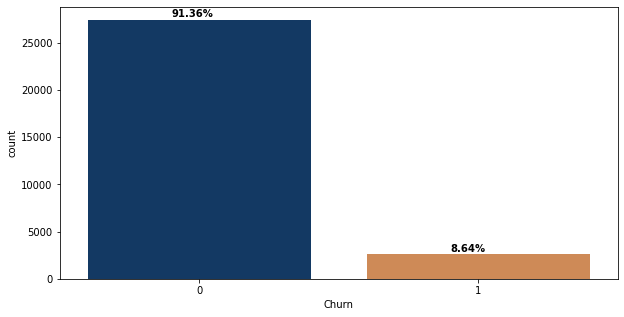

In [ ]:
#count percentage of customer that churn
count_plot(telecomfilter,'Churn')

#### Observation: only 8.64% data belong to churn customer

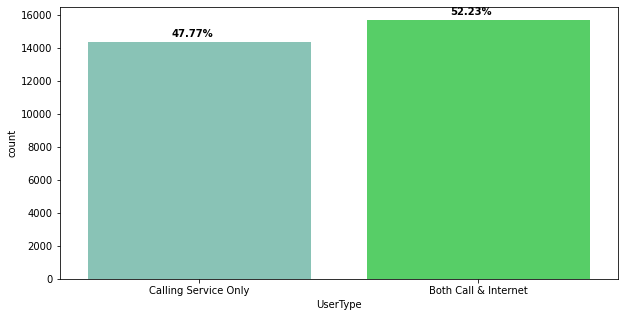

In [ ]:
#Count type of customer
count_plot(telecomfilter,'UserType',color=["#7fcdbb",'#43e259'])

#### Observation: 47.77% customer only uses Calling Service

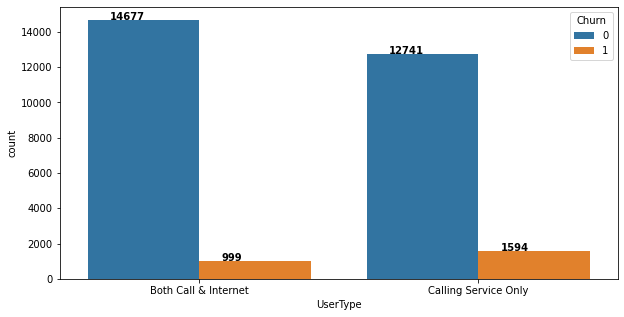

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x=telecomfilter['UserType'],hue=telecomfilter['Churn'],order=telecomfilter['UserType'].value_counts().index)
for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x()+0.08,p.get_height()),fontweight='bold')
plt.show()

In [ ]:
telecomfilter.groupby('UserType')['Churn'].value_counts(normalize=True)*100

UserType              Churn
Both Call & Internet  0        93.627201
                      1         6.372799
Calling Service Only  0        88.880363
                      1        11.119637
Name: Churn, dtype: float64

#### Observation: Customer those only uses Calling Service shows approx 11% churn

In [ ]:
#### Visualize calling time of Churn Customer

#Create a dataframe that contains only Churn Customers.
calling = telecomfilter[(telecomfilter['Churn']==1)]
calling.shape

(2593, 153)

In [ ]:
#Create new metrics TotalincomingTime: that store total incoming call time of customer 
calling['TotalincomingTime'] = 0
for i in range(6,9):
    calling['TotalincomingTime'] += calling['total_ic_mou_'+str(i)]

#Create new metrics TotaloutgoingTime: that store total outgoing call time of customer 
calling['TotaloutgoingTime'] = 0
for i in range(6,9):
    calling['TotaloutgoingTime'] +=  calling['total_og_mou_'+str(i)]


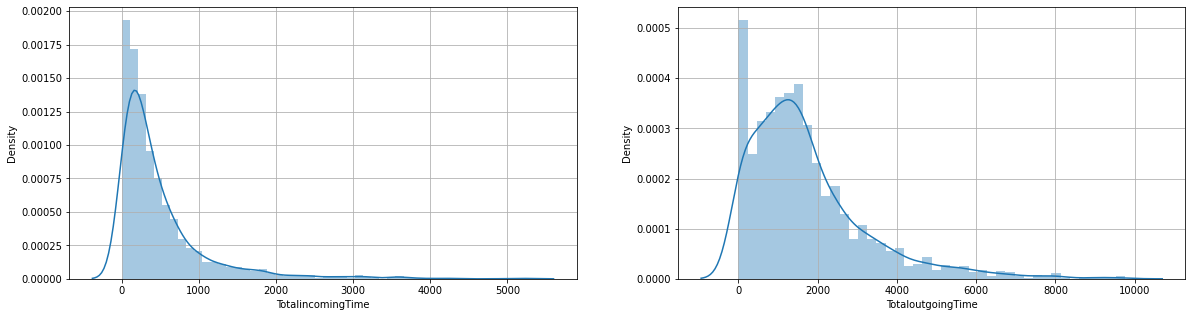

In [ ]:
# distplot for the TotalincomingTime and TotaloutgoingTime
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.grid()
ax = sns.distplot(calling['TotalincomingTime'])
plt.subplot(1, 2, 2)
plt.grid()
ax = sns.distplot(calling['TotaloutgoingTime'])
plt.show()

In [ ]:
calling[['TotalincomingTime','TotaloutgoingTime']].describe()

,TotalincomingTime,TotaloutgoingTime
count,2593.000000,2593.000000
mean,490.496262,1730.419026
std,607.220711,1508.659704
min,0.000000,0.000000
25%,129.490000,695.170000
50%,293.300000,1399.260000
75%,608.590000,2309.170000
max,5221.127000,9756.826000


#### Observation: On an average churn customer have higher outgoing call time.

In [ ]:
#### Further observation on outgoing call time

# Create new metrics StdOutTime: that store total STD outgoing call time of customer
calling['StdOutTime'] = 0
for i in range(6,9):
    calling['StdOutTime'] += calling['std_og_mou_'+str(i)]

#Create new metrics LocOutTime: that store total local outgoing call time of customer
calling['LocOutTime'] = 0
for i in range(6,9):
    calling['LocOutTime'] +=  calling['loc_og_mou_'+str(i)]


In [ ]:
calling[['StdOutTime','LocOutTime']].describe()

,StdOutTime,LocOutTime
count,2593.000000,2593.000000
mean,1312.900747,374.989161
std,1431.385691,551.309286
min,0.000000,0.000000
25%,95.500000,60.500000
50%,971.060000,173.050000
75%,1889.040000,455.920000
max,8420.011000,4948.153000


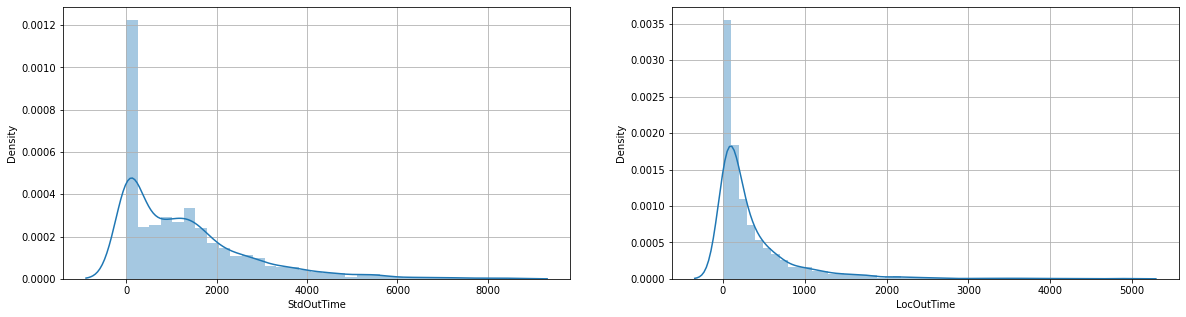

In [ ]:
#distplot for StdOutTime and LocOutTime
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.grid()
ax=sns.distplot(calling['StdOutTime'])
plt.subplot(1,2,2)
plt.grid()
ax=sns.distplot(calling['LocOutTime'])
plt.show()

#### Observation: Churn customer on an average have higher STD calling time

In [ ]:
#### Visualize Internet uses of Churn Customer

#Create a dataframe that contains only Churn Customers and type of customer that use Both Call & Internet 
internet = telecomfilter[(telecomfilter['UserType']=="Both Call & Internet")]
internet.shape

(15676, 153)

In [ ]:
#uIntType function that categorise the User based on Internet service use.
def uIntType(row):
    if (row['TotalRech-2G'] ==0 and row['TotalRech-3G'] > 0):
        userType= '3GUser'
    elif (row['TotalRech-2G'] >0 and row['TotalRech-3G'] == 0):
         userType= "2GUser"
    elif (row['TotalRech-2G'] >0 and row['TotalRech-3G']> 0):
        userType = "Both 2G-3GUser"
    else:
        userType = "None"
    return userType

internet['InternetUserType']= internet.apply(uIntType,axis=1)

In [ ]:
internet['InternetUserType'].value_counts()

2GUser            7816
Both 2G-3GUser    4621
3GUser            3239
Name: InternetUserType, dtype: int64

In [ ]:
internet.groupby('InternetUserType')['Churn'].value_counts(normalize=True)*100

InternetUserType  Churn
2GUser            0        93.513306
                  1         6.486694
3GUser            0        91.694968
                  1         8.305032
Both 2G-3GUser    0        95.174205
                  1         4.825795
Name: Churn, dtype: float64

#### Observation:  No such difference was found for the internet using type on churn rate

# Model Building and Evaluation

In [ ]:
# Drop Columns that are not needed

#mobile_number:contains unique mobile number, circle_id: same for all records i.e 109,
#loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou : same for all records i.e 0
#last_date_of_month_ : last day of the month
telecommodel = telecomfilter.copy()
telecommodel = telecommodel.drop(['mobile_number','circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                                   'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6',
                                   'date_of_last_rech_7','date_of_last_rech_8'],axis=1)

telecommodel.shape

(30011, 142)

In [ ]:
col = telecommodel.select_dtypes(('object'))
print("Total categorical variables",len(col.columns))

dummyvar = pd.get_dummies(telecommodel[col.columns],drop_first=True)
print("Total dummies variable created",dummyvar.shape[1])

#concat the created dummy variables with the dataset.
telecommodel = pd.concat([dummyvar,telecommodel],axis=1)

#Drop the variables for which dummy variable is created.
telecommodel=telecommodel.drop(col.columns,axis=1)
telecommodel.head()

Total categorical variables 2
Total dummies variable created 6


,AON_Y_2-4 Year,AON_Y_4-6 Year,AON_Y_6-8 Year,AON_Y_<1 Year,AON_Y_>8 Year,UserType_Calling Service Only,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,...,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_diff,TotalRech-2G,TotalRech-3G,TotalRech_2G-3G,InternetUser,TotalRech-Call,TotalRech-Call_Amnt,TotalDataUsed,TotalCallTime,Churn
7,1,0,0,0,0,1,1069.180,1349.8500,1987.9344,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,...,790.0,2341.9,1000,790,951,0,0,619,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,864.34085,0,0,0,0,17,6008.0,0.00,51.00,1
8,0,0,0,1,0,0,378.721,492.2230,137.3620,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,...,601.0,120.0,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0.0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,-298.11000,5,0,5,1,54,1158.0,1118.92,21.01,0
13,0,0,1,0,0,0,492.846,205.6710,593.2600,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,...,253.0,717.0,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0.0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,244.00150,3,0,3,1,21,1477.0,0.02,73.34,0
16,0,0,0,0,0,1,430.975,299.8690,187.8940,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99,...,348.0,160.0,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,-177.52800,0,0,0,0,18,1078.0,0.00,31.78,0
17,0,0,0,0,0,1,690.008,25.7827,25.4990,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,97.54,0.00,0.00,1146.91,0.81,0.00,1.55,...,0.0,30.0,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,-328.99500,0,0,0,0,25,846.0,0.00,22.41,0


#### Test Train Split

In [ ]:
# Putting predictive variable to y
y = telecommodel.pop('Churn')

# Putting feature variable to X
X = telecommodel

# Print shape of X and y
print("X shape " + str(X.shape))
print("y shape " + str(y.shape))

X shape (30011, 145)
y shape (30011,)


In [ ]:
#Split Train data into 70% and Test data in 30%.
# Use stratify parameter to make a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=42,stratify=y)


# Print shape of X and y
print("X_train shape ",X_train.shape)
print("y_train shape ",y_train.shape)
print("")
print("X_test shape ",X_test.shape)
print("y_test shape ",y_test.shape)

X_train shape  (21007, 145)
y_train shape  (21007,)

X_test shape  (9004, 145)
y_test shape  (9004,)


#### Scaling

In [ ]:
#Use StandardScaler to fit the training set.
#StandardScaler removes the mean and scales each feature/variable to unit variance.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)

#### Reduce the number of Variables using PCA

In [ ]:
#Fit PCA on the trianing data set.
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_ratio_

array([1.13039900e-01, 9.40065219e-02, 6.80409459e-02, 5.06210673e-02,
       4.41128697e-02, 3.45281148e-02, 3.01598273e-02, 2.75682828e-02,
       2.64689718e-02, 2.46619843e-02, 2.23542635e-02, 2.18710318e-02,
       1.94699205e-02, 1.81601861e-02, 1.69466873e-02, 1.60422741e-02,
       1.49518578e-02, 1.30910974e-02, 1.30359247e-02, 1.25661336e-02,
       1.11241749e-02, 1.02933583e-02, 1.00412229e-02, 9.81013551e-03,
       9.74689038e-03, 9.20529691e-03, 8.50479238e-03, 8.29751839e-03,
       8.13888701e-03, 7.87990184e-03, 7.74093727e-03, 7.65636736e-03,
       7.31013507e-03, 7.10004540e-03, 6.61351260e-03, 6.47988250e-03,
       6.40622026e-03, 6.25155760e-03, 5.96545818e-03, 5.87169392e-03,
       5.39506086e-03, 5.38390583e-03, 5.18134276e-03, 5.05699905e-03,
       4.96982020e-03, 4.91302480e-03, 4.64774476e-03, 4.46171454e-03,
       4.29346179e-03, 4.19687417e-03, 4.09020116e-03, 3.95794833e-03,
       3.80005919e-03, 3.71322392e-03, 3.47033011e-03, 3.45059737e-03,
      

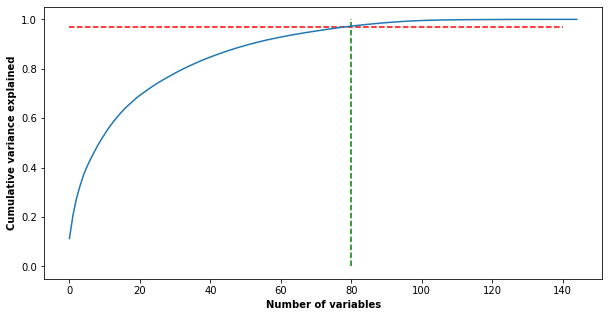

In [ ]:
#Plot cumulative variance explained vs number of variables.
varcum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10,5))
plt.hlines(y=0.97,xmax=140,xmin=0,colors='r',linestyles="--")
plt.vlines(x=80,ymax=1,ymin=0,colors='g',linestyles="--")
plt.plot(varcum)
plt.ylabel("Cumulative variance explained",fontweight='bold')
plt.xlabel("Number of variables",fontweight='bold')
plt.show()

#### Observation: 97% of variance explained by 80 variables.

In [ ]:
#Reduce dimensionality of trainig dataset using incremental PCA.
pca = IncrementalPCA(n_components=80)
X_train = pca.fit_transform(X_train)

#Shape of training data set after removing variables
X_train.shape

(21007, 80)

### Logistic Regression Model

In [ ]:
#Instantiate a Logistic Regression Moldel.
lr = LogisticRegression(random_state=42,class_weight="balanced")

In [ ]:
#Hyperparameter tuning for Logistic Regression
logparams = {'penalty': ['l1', 'l2'],
             'C': [0.01, 0.1, 1, 10, 100]}
            

model_logregression = GridSearchCV(estimator=lr, param_grid=logparams, cv=4, n_jobs=-1,verbose=1,scoring="recall")

In [ ]:
%%time
#Fit the model on the training dataset.
model_logregression.fit(X_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


CPU times: user 457 ms, sys: 183 ms, total: 640 ms
Wall time: 3.52 s


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [ ]:
#Best estimator values for Decision Tree classifier model.
model_logregression.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#RandomForest model with best hyper parameter value.
model_logregressionbest = model_logregression.best_estimator_

#Predict y on the train data
y_train_Logpred = model_logregressionbest.predict(X_train)

In [ ]:
#Accuracy on train data set.
metrics.accuracy_score(y_train,y_train_Logpred)

0.8235350121388109

In [ ]:
#Confusion Matrix
metrics.confusion_matrix(y_train,y_train_Logpred)

array([[15766,  3426],
       [  281,  1534]])

In [ ]:
#classification report for the Decision Tree Classifier model.
print(metrics.classification_report(y_train,y_train_Logpred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     19192
           1       0.31      0.85      0.45      1815

    accuracy                           0.82     21007
   macro avg       0.65      0.83      0.67     21007
weighted avg       0.92      0.82      0.86     21007



### Decision Tree Classifier Model

In [ ]:
#Instantiate Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42,class_weight="balanced")

In [ ]:
#Hyperparameter tuninig for Decision Tree classifier model.
dtparams = { 
          'max_depth': [3,5,10],
          'min_samples_leaf': [50,100,200,500],
          'min_samples_split': [50,75,100],
          'criterion':['gini','entropy'],
          'max_features': ['auto','sqrt','log2']}

model_decisiontree = GridSearchCV(estimator=dt, param_grid=dtparams, cv=4, n_jobs=-1,verbose=1,scoring="recall")

In [ ]:
%%time
#Fit the model on the training dataset.
model_decisiontree.fit(X_train,y_train)

Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   27.6s


CPU times: user 3.14 s, sys: 223 ms, total: 3.36 s
Wall time: 1min 20s


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.3min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'crit

In [ ]:
#Best estimator values for Decision Tree classifier model.
model_decisiontree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
#DecisionTree model with best hyper parameter value.
model_decisiontreebest = model_decisiontree.best_estimator_

#predict the target variable.
y_train_dtpred = model_decisiontreebest.predict(X_train)

In [ ]:
#Accuracy on train data set.
metrics.accuracy_score(y_train,y_train_dtpred)

0.7137144761270053

In [ ]:
#Confusion Matrix
metrics.confusion_matrix(y_train,y_train_dtpred)

array([[13590,  5602],
       [  412,  1403]])

In [ ]:
#classification report for the Decision Tree Classifier model.
print(metrics.classification_report(y_train,y_train_dtpred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     19192
           1       0.20      0.77      0.32      1815

    accuracy                           0.71     21007
   macro avg       0.59      0.74      0.57     21007
weighted avg       0.90      0.71      0.78     21007



### Random Forest Classifier Model

In [ ]:
#Instantiate Random Forest classifier.
rf = RandomForestClassifier(random_state=42,class_weight="balanced")

In [ ]:
#Hyperparameter tuning for Random Forest classifier Model.
rfparams = {'n_estimators': [10,25,50,100,200],
            'max_depth': [3,5,10],
            'min_samples_leaf': [20,50,100,200],
            'max_features': ['auto', 'sqrt']}

model_randomforest = GridSearchCV(estimator=rf,param_grid=rfparams,cv=4,verbose=1,n_jobs=-1,scoring="recall")

In [ ]:
%%time
#Fit the model on the training dataset.
model_randomforest.fit(X_train,y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 25.6min finished


CPU times: user 18.9 s, sys: 1.07 s, total: 20 s
Wall time: 25min 48s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                            

In [ ]:
#Random Forest best estimators.
model_randomforest.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#RandomForest model with best hyper parameter value.
model_randomforestbest = model_randomforest.best_estimator_

#predict the target variable.
y_train_rfpred =model_randomforestbest.predict(X_train)

In [ ]:
#Print accuracy of the model.
print(metrics.accuracy_score(y_train,y_train_rfpred))

0.8336268862760032


In [ ]:
#Classification Report for Random Forest classifier Model.
print(metrics.classification_report(y_train,y_train_rfpred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90     19192
           1       0.31      0.79      0.45      1815

    accuracy                           0.83     21007
   macro avg       0.65      0.81      0.68     21007
weighted avg       0.92      0.83      0.86     21007



## KNN Model

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
#Hyperparameter tuning for Random Forest classifier Model.
knnparams =  {
             'n_neighbors': [10,20,50,100],
              'leaf_size':[40,50,100],
             'weights': ['uniform','distance']}

model_knn = GridSearchCV(estimator=knn,param_grid=knnparams,cv=4,verbose=1,n_jobs=-1,scoring="recall")

In [ ]:
%%time
model_knn.fit(X_train,y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 13.4min finished


CPU times: user 4.25 s, sys: 500 ms, total: 4.75 s
Wall time: 13min 25s


GridSearchCV(cv=4, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'leaf_size': [40, 50, 100],
                         'n_neighbors': [10, 20, 50, 100],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [ ]:
#KNN model best estimators.
model_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [ ]:
#KNN model with best hyper parameter value.
model_knnbest = model_knn.best_estimator_

#predict the target variable.
y_train_knnpred = model_knnbest.predict(X_train)

In [ ]:
#Print accuracy of the model.
print(metrics.accuracy_score(y_train,y_train_knnpred))

1.0


In [ ]:
#Confusion Matrix
metrics.confusion_matrix(y_train,y_train_knnpred)

array([[19192,     0],
       [    0,  1815]])

In [ ]:
#Classification Report for KNN Model.
print(metrics.classification_report(y_train,y_train_knnpred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19192
           1       1.00      1.00      1.00      1815

    accuracy                           1.00     21007
   macro avg       1.00      1.00      1.00     21007
weighted avg       1.00      1.00      1.00     21007



### GBM Classifier Model

In [ ]:
#Instatiate the GradientBoosting Classifier
gbm = GradientBoostingClassifier(random_state=42)

In [ ]:
#Hyperparameter tuning for Gradient Boosting classifier
gbmparams = {'n_estimators': [50,150,200],   # no of Trees 
            'learning_rate' : [0.001,0.1,0.2,1.0],
            'max_depth': [3,5,10],
            'max_features' : ['auto', 'sqrt', 'log2']}

model_gbm = RandomizedSearchCV(estimator=gbm,param_distributions=gbmparams,n_iter=50,cv=4,n_jobs=-1,verbose=1,scoring="recall")

In [ ]:
%%time
model_gbm.fit(X_train,y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 133.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 134.9min finished


CPU times: user 3min 26s, sys: 4.88 s, total: 3min 31s
Wall time: 2h 17min 42s


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [ ]:
#GBM model best estimators.
model_gbm.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#KNN model with best hyper parameter value.
model_gbmbest = model_gbm.best_estimator_

#predict the target variable.
y_train_gbmpred = model_gbmbest.predict(X_train)

In [ ]:
#Print accuracy of the model.
print(metrics.accuracy_score(y_train,y_train_gbmpred))

0.9891940781644214


In [ ]:
#Classification Report for GBM classifier Model.
print(metrics.classification_report(y_train,y_train_gbmpred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19192
           1       0.99      0.88      0.93      1815

    accuracy                           0.99     21007
   macro avg       0.99      0.94      0.96     21007
weighted avg       0.99      0.99      0.99     21007



### XGBoost Classifier Model

In [ ]:
#Intatiate XGBoost classifier.
xgboost = xgb.XGBClassifier( objective='binary:logistic',random_state=42)

In [ ]:
# hyperparameter tuning for XGBoost classifier model
xgparams = {
        'n_estimators' : [100, 200, 500], # no of trees 
        'learning_rate' : [0.05, 0.1, 0.25],  # eta
        'min_child_weight': [ 5, 7, 10],
        'gamma': [ 0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 12]
        }


model_xgboost = RandomizedSearchCV(xgboost, param_distributions=xgparams, scoring='recall',n_iter=20, n_jobs=4, cv=4, verbose=1)

In [ ]:
%%time
#Fit the model.
model_xgboost.fit(X_train,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 17.8min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 38.5min finished


CPU times: user 1min 10s, sys: 1.3 s, total: 1min 11s
Wall time: 39min 32s


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, s...
                   iid='deprecated', n_iter=20, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'g

In [ ]:
#Best estimator of XGboost model.
model_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
#Best parameter for XGBoost using hyperparameter tuning.
model_xgboost.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 10,
 'n_estimators': 200,
 'subsample': 0.8}

In [ ]:
#XGBoost classifier  model with best hyper parameter value.
model_xgboostbest = model_xgboost.best_estimator_

#predict the target variable.
y_train_xgbpred = model_xgboostbest.predict(X_train)

In [ ]:
#Print accuracy of the model.
print(metrics.accuracy_score(y_train,y_train_xgbpred))

0.98424334745561


In [ ]:
#Classification report of XGBoost Model
print(metrics.classification_report(y_train,y_train_xgbpred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19192
           1       1.00      0.82      0.90      1815

    accuracy                           0.98     21007
   macro avg       0.99      0.91      0.95     21007
weighted avg       0.98      0.98      0.98     21007



## Model Evaluation

In [ ]:
#function to evaluate model on the test data set.
def evaluateModel(model,modelName=None):
    print("\n"+'\033[1m'+str(modelName)+" Test Accuracy Score:"+'\033[0m', 
        round(metrics.accuracy_score(y_test, model.predict(X_test)),2)*100)
    print("\n"+'\033[1m'+str(modelName)+" Test Confusion Matrix:"+'\033[0m')
    cm = metrics.confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm)
    print("\n"+'\033[1m'+str(modelName)+" Test Classification Report:"+'\033[0m')
    print(metrics.classification_report(y_test,model.predict(X_test)))
    print("*"*70)
    print('\033[1m'+"\n ROC CURVE"+'\033[0m')
    metrics.plot_roc_curve(model,X_test,y_test,drop_intermediate=False)
    plt.show()

#Function for Confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(['Not Churn','Churn']))
    plt.xticks(tick_marks, ['Not Churn','Churn'], rotation=45)
    plt.yticks(tick_marks, ['Not Churn','Churn'])

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#### Scaling 

In [ ]:
#Scaling of teatdata set.
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

#### PCA

In [ ]:
#PCA on Testdata set.
X_test = pca.transform(X_test)

#Shape of Testdata set after PCA.
X_test.shape

(9004, 80)

### Model Evaluation :  Logistic Regression


Logistic Regression Model Test Accuracy Score: 82.0

Logistic Regression Model Test Confusion Matrix:

Logistic Regression Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8226
           1       0.30      0.82      0.44       778

    accuracy                           0.82      9004
   macro avg       0.64      0.82      0.66      9004
weighted avg       0.92      0.82      0.85      9004

**********************************************************************

 ROC CURVE


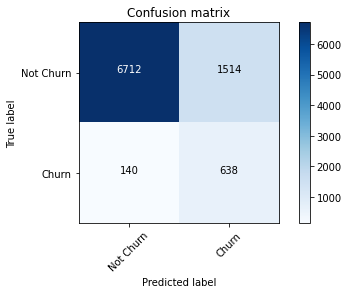

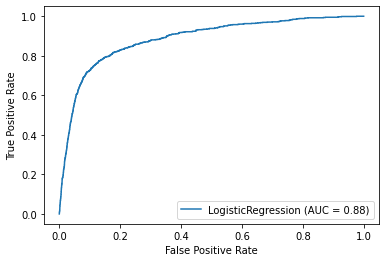

In [ ]:
evaluateModel(model_logregressionbest,"Logistic Regression Model")

### Model Evaluation: Decision Tree Classifier


Decision Tree Classifier Model Test Accuracy Score: 71.0

Decision Tree Classifier Model Test Confusion Matrix:

Decision Tree Classifier Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      8226
           1       0.20      0.77      0.32       778

    accuracy                           0.71      9004
   macro avg       0.58      0.74      0.57      9004
weighted avg       0.90      0.71      0.77      9004

**********************************************************************

 ROC CURVE


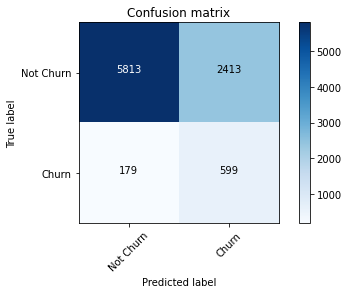

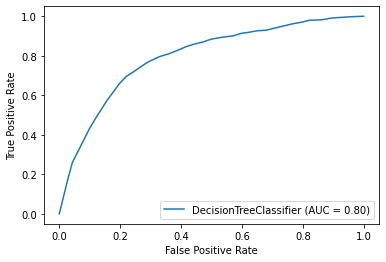

In [ ]:
evaluateModel(model_decisiontreebest,"Decision Tree Classifier Model")

### Model Evaluation: Random Forest Classifier


Random Forest Classifier Model Test Accuracy Score: 83.0

Random Forest Classifier Model Test Confusion Matrix:

Random Forest Classifier Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      8226
           1       0.30      0.77      0.44       778

    accuracy                           0.83      9004
   macro avg       0.64      0.80      0.67      9004
weighted avg       0.92      0.83      0.86      9004

**********************************************************************

 ROC CURVE


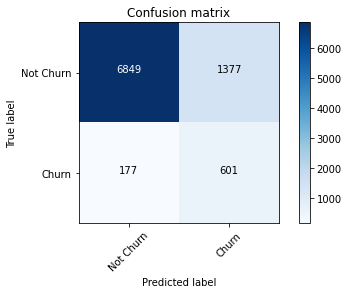

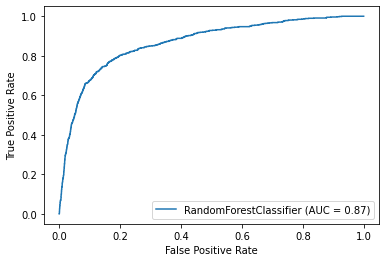

In [ ]:
evaluateModel(model_randomforestbest,"Random Forest Classifier Model")

### Model Evaluation KNN Classification Model


KNN Classification Model Test Accuracy Score: 92.0

KNN Classification Model Test Confusion Matrix:

KNN Classification Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8226
           1       0.59      0.31      0.41       778

    accuracy                           0.92      9004
   macro avg       0.76      0.65      0.68      9004
weighted avg       0.91      0.92      0.91      9004

**********************************************************************

 ROC CURVE


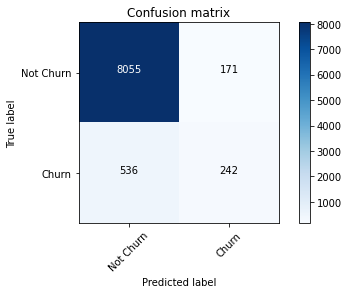

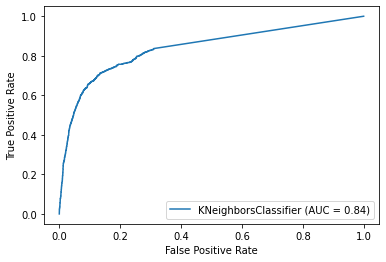

In [ ]:
evaluateModel(model_knnbest,"KNN Classification Model")


GBM Classification Model Test Accuracy Score: 92.0

GBM Classification Model Test Confusion Matrix:

GBM Classification Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      8226
           1       0.57      0.40      0.47       778

    accuracy                           0.92      9004
   macro avg       0.76      0.68      0.71      9004
weighted avg       0.91      0.92      0.92      9004

**********************************************************************

 ROC CURVE


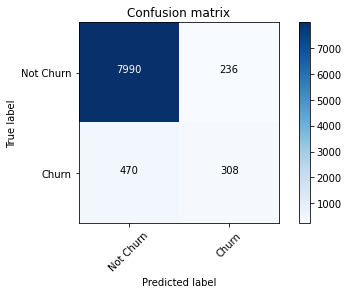

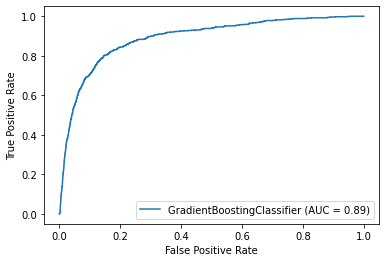

In [ ]:
evaluateModel(model_gbmbest,"GBM Classification Model")


XGBoost Classification Model Test Accuracy Score: 93.0

XGBoost Classification Model Test Confusion Matrix:

XGBoost Classification Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8226
           1       0.66      0.37      0.47       778

    accuracy                           0.93      9004
   macro avg       0.80      0.67      0.72      9004
weighted avg       0.92      0.93      0.92      9004

**********************************************************************

 ROC CURVE


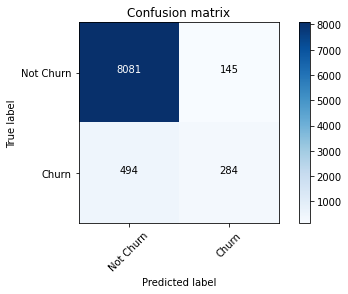

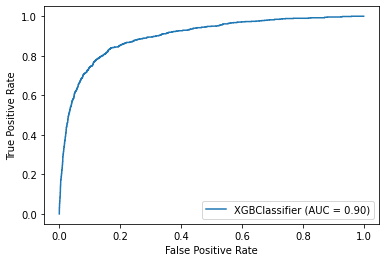

In [ ]:
evaluateModel(model_xgboostbest,"XGBoost Classification Model")

In [ ]:
#Function return metrics score of the model. 
def modelEvaluation(model,Model_Name):
    score = []
    
    score.append(metrics.recall_score(y_train,model.predict(X_train)))
    score.append(metrics.recall_score(y_test,model.predict(X_test)))
    
    score.append(metrics.roc_auc_score(y_train,model.predict(X_train)))
    score.append(metrics.roc_auc_score(y_test,model.predict(X_test)))
    
    score.append(metrics.f1_score(y_train,model.predict(X_train)))
    score.append(metrics.f1_score(y_test,model.predict(X_test)))
   
    score.append(metrics.accuracy_score(y_train,model.predict(X_train)))
    score.append(metrics.accuracy_score(y_test,model.predict(X_test)))
    
    return pd.Series(score,name=Model_Name)


#Function which returrn table that contains metrics of the models.
def finalScoreMetrics(models):
    score_table = {'Metrics' : ['Recall Score (Train)','Recall Score (Test)','ROC-AUC Score (Train)','ROC-AUC Score (Test)',
                        'F1 Score (Train)', 'F1 Score (Test)', 'Accuracy Score (Train)','Accuracy Score (Test)']}
    score_metrics = pd.DataFrame(score_table,columns=['Metrics'])
    models.insert(0,score_metrics)
    score_metrics = pd.concat([x for x in models],axis=1)
    return score_metrics  


#Function to compare ROC for all the models.
def pltroc(models):
    ax = plt.gca()
    for i in models:
        metrics.plot_roc_curve(i, X_test, y_test, ax=ax)   
    plt.plot([0,1],[0,1], 'k--')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title("ROC curve comparison",fontweight="bold")
    plt.show()

In [ ]:

LOGISTIC = modelEvaluation(model_logregressionbest,"Logistic Regression Model")
DECISIONTREE = modelEvaluation(model_decisiontreebest,"Decision Tree Model")
RANDOMFOREST = modelEvaluation(model_randomforestbest,"Random Forest Model")
KNN =  modelEvaluation(model_knnbest,"KNNModel")
GBM =  modelEvaluation(model_gbmbest,"GBM Model")
XGBOOST =  modelEvaluation(model_xgboostbest,"XGBoost Model")

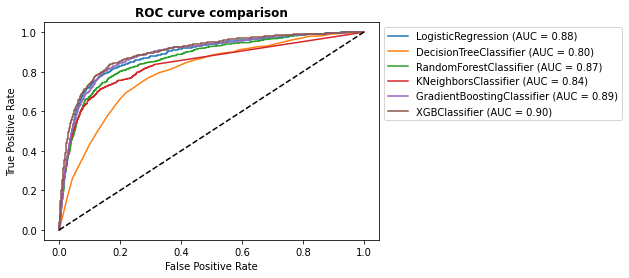

In [ ]:
#ROC Comparision for all the models.
pltroc([model_logregressionbest,model_decisiontreebest,model_randomforestbest,model_knnbest,model_gbmbest,model_xgboostbest])

In [ ]:
#Score Metrics for all the models.
finalScoreMetrics([LOGISTIC,DECISIONTREE,RANDOMFOREST,KNN,GBM,XGBOOST])

,Metrics,Logistic Regression Model,Decision Tree Model,Random Forest Model,KNNModel,GBM Model,XGBoost Model
0,Recall Score (Train),0.845179,0.773003,0.785675,1.000000,0.882645,0.818182
1,Recall Score (Test),0.820051,0.769923,0.772494,0.311054,0.395887,0.365039
2,ROC-AUC Score (Train),0.833334,0.740555,0.811918,1.000000,0.940958,0.909065
3,ROC-AUC Score (Test),0.818000,0.738292,0.802549,0.645133,0.683599,0.673706
4,F1 Score (Train),0.452841,0.318141,0.449346,1.000000,0.933839,0.899727
5,F1 Score (Test),0.435495,0.316095,0.436139,0.406381,0.465961,0.470588
6,Accuracy Score (Train),0.823535,0.713714,0.833627,1.000000,0.989194,0.984243
7,Accuracy Score (Test),0.816304,0.712128,0.827410,0.921479,0.921590,0.929032


__Conclusion :__

## Model: To identify important variables that are strong predictors of churn

- Using Decision to identify the important variables

In [ ]:
#Dataset
telecom_model_2 = telecomfilter.copy()
telecom_model_2.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,...,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_diff,AON_Y,TotalRech-2G,TotalRech-3G,TotalRech_2G-3G,InternetUser,TotalRech-Call,TotalRech-Call_Amnt,UserType,TotalDataUsed,TotalCallTime,Churn
7,7000701601,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,1069.180,1349.8500,1987.9344,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,...,2014-06-27 00:00:00,2014-07-25 00:00:00,2014-08-26 00:00:00,0,0,619,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,864.34085,2-4 Year,0,0,0,0,17,6008.0,Calling Service Only,0.00,51.00,1
8,7001524846,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,378.721,492.2230,137.3620,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,...,2014-06-25 00:00:00,2014-07-31 00:00:00,2014-08-30 00:00:00,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0.0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,-298.11000,<1 Year,5,0,5,1,54,1158.0,Both Call & Internet,1118.92,21.01,0
13,7002191713,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,492.846,205.6710,593.2600,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,...,2014-06-20 00:00:00,2014-07-22 00:00:00,2014-08-30 00:00:00,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0.0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,244.00150,6-8 Year,3,0,3,1,21,1477.0,Both Call & Internet,0.02,73.34,0
16,7000875565,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,430.975,299.8690,187.8940,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,315.91,215.64,205.93,7.89,2.58,...,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-14 00:00:00,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,-177.52800,1-2 Year,0,0,0,0,18,1078.0,Calling Service Only,0.00,31.78,0
17,7000187447,109,0.0,0.0,0.0,2014-06-30,2014-07-31 00:00:00,2014-08-31 00:00:00,690.008,25.7827,25.4990,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,97.54,0.00,0.00,1146.91,0.81,...,2014-06-30 00:00:00,2014-07-30 00:00:00,2014-08-25 00:00:00,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,-328.99500,1-2 Year,0,0,0,0,25,846.0,Calling Service Only,0.00,22.41,0


In [ ]:
#Drop the columns that are not required.
telecom_model_2 = telecom_model_2.drop(['mobile_number','circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                                   'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6',
                                   'date_of_last_rech_7','date_of_last_rech_8'],axis=1)

telecom_model_2.shape

(30011, 142)

In [ ]:
#Dummy Variable creation

col = telecom_model_2.select_dtypes(('object'))
print("Total categorical variables",len(col.columns))

dummyvar = pd.get_dummies(telecom_model_2[col.columns],drop_first=True)
print("Total dummies variable created",dummyvar.shape[1])

#concat the created dummy variables with the dataset.
telecom_model_2 = pd.concat([dummyvar,telecom_model_2],axis=1)

#Drop the variables for which dummy variable is created.
telecom_model_2=telecom_model_2.drop(col.columns,axis=1)
telecom_model_2.head()

Total categorical variables 2
Total dummies variable created 6


,AON_Y_2-4 Year,AON_Y_4-6 Year,AON_Y_6-8 Year,AON_Y_<1 Year,AON_Y_>8 Year,UserType_Calling Service Only,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,...,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_diff,TotalRech-2G,TotalRech-3G,TotalRech_2G-3G,InternetUser,TotalRech-Call,TotalRech-Call_Amnt,TotalDataUsed,TotalCallTime,Churn
7,1,0,0,0,0,1,1069.180,1349.8500,1987.9344,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,...,790.0,2341.9,1000,790,951,0,0,619,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,864.34085,0,0,0,0,17,6008.0,0.00,51.00,1
8,0,0,0,1,0,0,378.721,492.2230,137.3620,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,...,601.0,120.0,90,154,30,50,0,10,0.0,356.0,0.03,0.0,750.95,11.94,0,1,0,0.0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,-298.11000,5,0,5,1,54,1158.0,1118.92,21.01,0
13,0,0,1,0,0,0,492.846,205.6710,593.2600,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,...,253.0,717.0,110,110,130,110,50,0,0.0,0.0,0.02,0.0,0.00,0.00,0,0,0,0.0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,244.00150,3,0,3,1,21,1477.0,0.02,73.34,0
16,0,0,0,0,0,1,430.975,299.8690,187.8940,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,315.91,215.64,205.93,7.89,2.58,3.23,22.99,...,348.0,160.0,110,110,130,100,100,130,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,511,0.00,2.45,21.89,-177.52800,0,0,0,0,18,1078.0,0.00,31.78,0
17,0,0,0,0,0,1,690.008,25.7827,25.4990,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,8.46,13.34,38.99,0.00,0.00,58.54,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,97.54,0.00,0.00,1146.91,0.81,0.00,1.55,...,0.0,30.0,110,0,30,30,0,0,0.0,0.0,0.00,0.0,0.00,0.00,0,0,0,0.0,0,0,0,0,0,0,0,0,667,0.00,0.00,0.00,-328.99500,0,0,0,0,25,846.0,0.00,22.41,0


### Test Train Split

In [ ]:
# Putting feature variable to X
X = telecom_model_2.drop(['Churn'], axis=1)

# Putting response variable to y
y = telecom_model_2['Churn']

In [ ]:
#Splitting the data into test and train
X_train_m2,X_test_m2,y_train_m2,y_test_m2 = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

# Print shape of X and y
print("X_train_m2 shape ",X_train_m2.shape)
print("y_train_m2 shape ",y_train_m2.shape)
print("")
print("X_test shape_m2 ",X_test_m2.shape)
print("y_test shape_m2 ",y_test_m2.shape)

X_train_m2 shape  (21007, 145)
y_train_m2 shape  (21007,)

X_test shape_m2  (9004, 145)
y_test shape_m2  (9004,)


In [ ]:
#Import library that are used to display the Decision Tree.
from IPython.display import Image  
from six import StringIO 
from sklearn.tree import export_graphviz
import pydotplus,graphviz

In [ ]:
#PATH configuration to run graphviz
#import os
#os.environ['PATH']=os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [ ]:
#Function that return decision tree.
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Non Churn','Churn'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [ ]:
#Instantiate Decision Tree Classifier
model2dt = DecisionTreeClassifier(random_state=42,class_weight="balanced")

In [ ]:
#Hyperparameter tuninig for Decision Tree classifier model.
model2dtparams = { 
          'max_depth': [3,5,10],
          'min_samples_leaf': [50,100,200,500],
          'min_samples_split': [50,75,100],
          'criterion':['gini','entropy'],
          'max_features': ['auto','sqrt','log2']}

model2_decisiontree = GridSearchCV(estimator=model2dt, param_grid=model2dtparams, cv=4, n_jobs=-1,verbose=1,scoring="recall")

In [ ]:
%%time
#Fit the model on the training dataset.
model2_decisiontree.fit(X_train_m2,y_train_m2)

Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   59.2s


CPU times: user 4.78 s, sys: 402 ms, total: 5.18 s
Wall time: 1min 6s


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.1min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'crit

In [ ]:
#DecisionTree model with best hyper parameter value.
model2_dt_best = model2_decisiontree.best_estimator_

#predict the target variable.
y_train_dtpred_model2 = model2_dt_best.predict(X_train_m2)

In [ ]:
#Classification Report
print(metrics.classification_report(y_train_m2,y_train_dtpred_model2))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91     19192
           1       0.35      0.80      0.48      1815

    accuracy                           0.85     21007
   macro avg       0.66      0.83      0.70     21007
weighted avg       0.92      0.85      0.88     21007



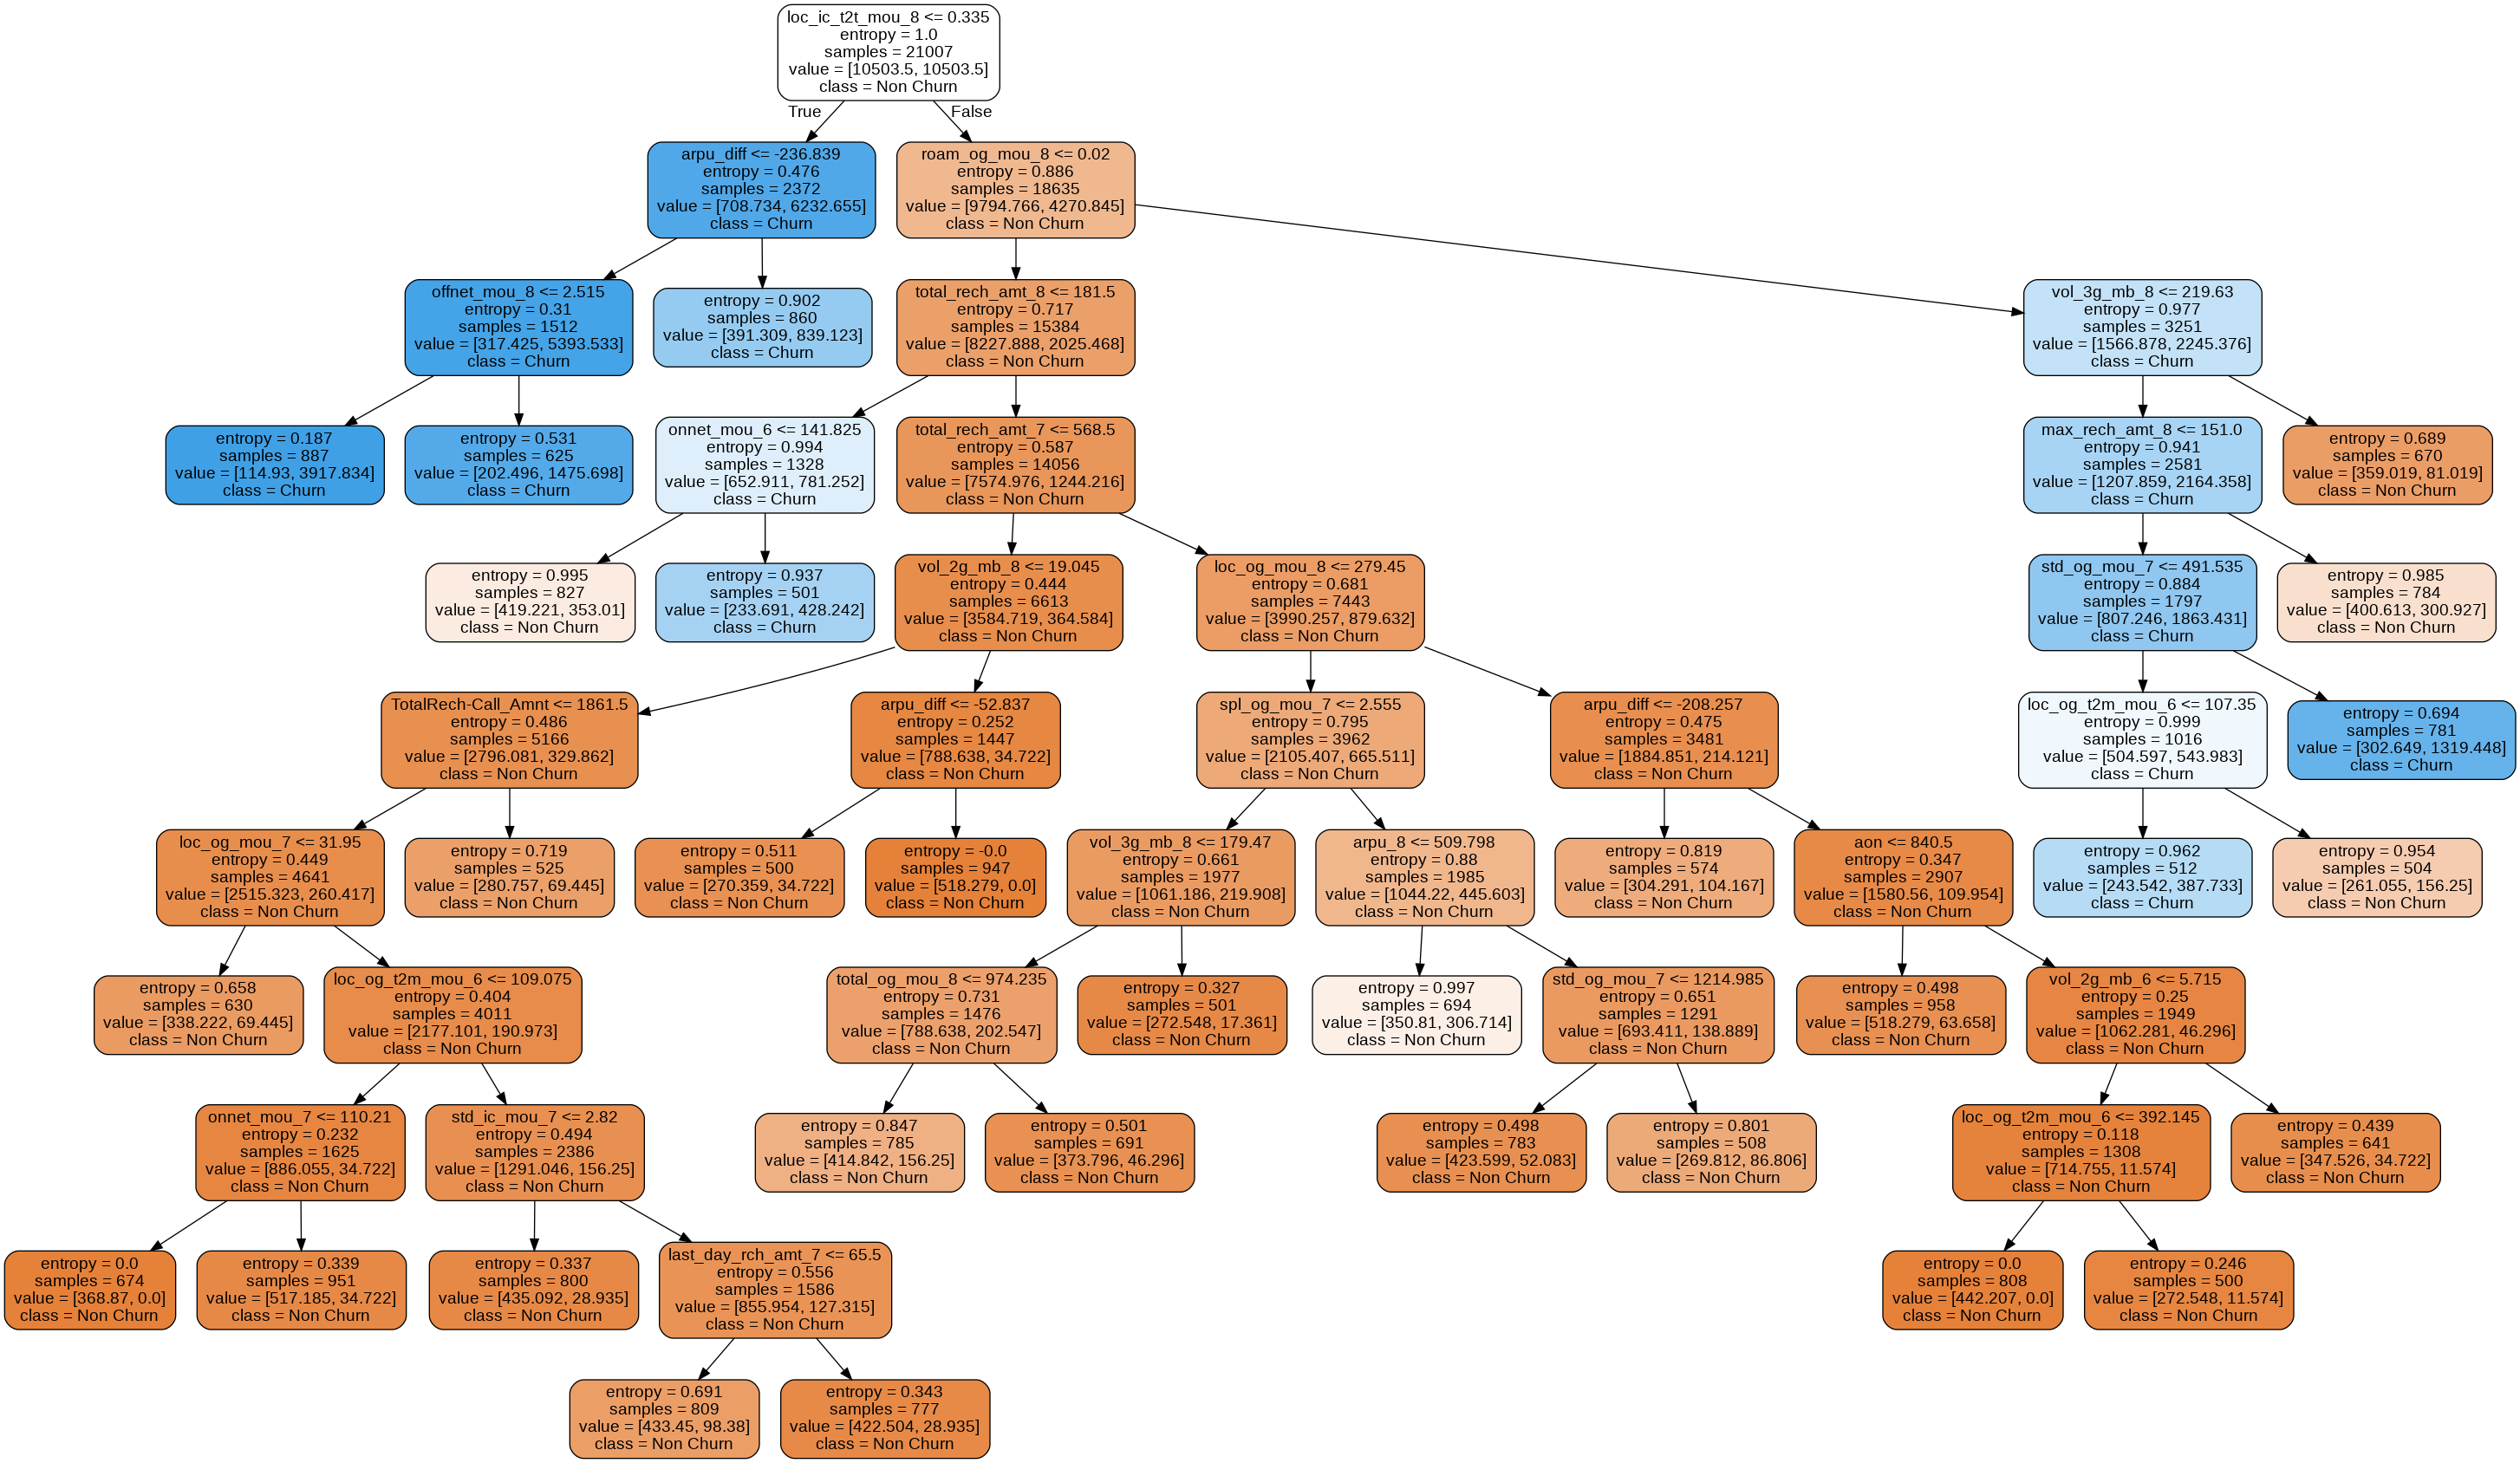

In [ ]:
#Decision Tree for the best estimator.
gph = get_dt_graph(model2_dt_best)
Image(gph.create_png())

In [ ]:
#Series that contains top 23 important features.
feature_scores = pd.Series(model2_dt_best.feature_importances_, index=X_train_m2.columns).sort_values(ascending=False).nlargest(23)
feature_scores

loc_ic_t2t_mou_8       0.560221
roam_og_mou_8          0.147495
total_rech_amt_8       0.079877
arpu_diff              0.058812
vol_3g_mb_8            0.029487
std_og_mou_7           0.022005
offnet_mou_8           0.013183
max_rech_amt_8         0.012974
loc_og_mou_8           0.012494
arpu_8                 0.012225
total_rech_amt_7       0.011182
loc_og_t2m_mou_6       0.009376
spl_og_mou_7           0.004811
onnet_mou_6            0.004021
total_og_mou_8         0.003240
vol_2g_mb_8            0.002823
onnet_mou_7            0.002807
last_day_rch_amt_7     0.002586
vol_2g_mb_6            0.002552
TotalRech-Call_Amnt    0.002333
loc_og_mou_7           0.002173
aon                    0.002083
std_ic_mou_7           0.001240
dtype: float64

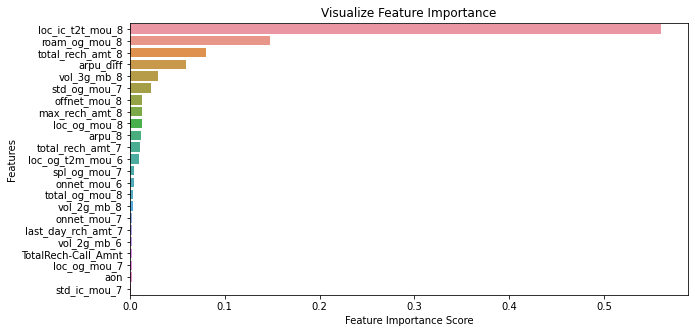

In [ ]:
#Visualize top features.
ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=feature_scores,y=feature_scores.index)
ax.set_title("Visualize Feature Importance")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.show()

## Strategies to manage customer churn.
- Provide cheap Roaming plans to the customers.
- Provide cheap STD plans to the customers.
- Provide 3G Internet pack with more MB at low cost.

# Feature Importance using Logistic Regression

### Feature Scaling

In [ ]:
#Use StandardScaler to fit the training set.
#StandardScaler removes the mean and scales each feature/variable to unit variance.
scaler_m2 = StandardScaler()
X_train_m2 = pd.DataFrame(scaler_m2.fit_transform(X_train_m2),columns=X_train_m2.columns)

### Correlation Check

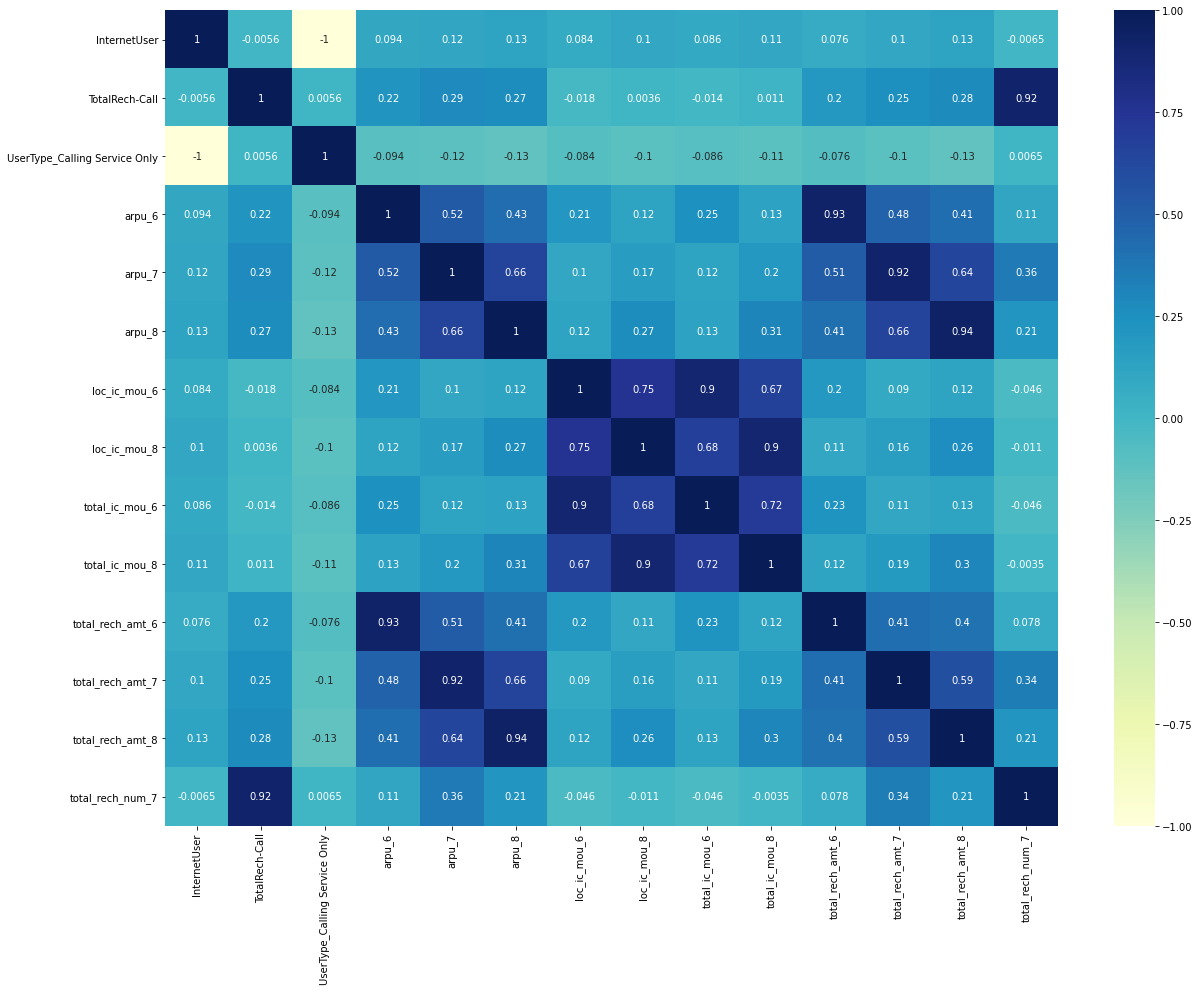

In [ ]:
#Function to return variables correlation that are above the given threshold
def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

#Plot heat map (threshold above 90)
plt.figure(figsize=(20,15))
sns.heatmap(absHighPass(telecom_model_2.corr(),0.9),annot=True,cmap="YlGnBu")
plt.show()

#### Observation:
- UserType_CallingServiceOnly and Internet User are 100% negatively correlated.
- arpu_6 and total_rech_amt_6 are 93% positively correlated.
- arpu_7 and total_rech_amt_7 are 92% positively correlated.
- arpu_8 and total_rech_amt_8 are 94% positively correlated.
- total_ic_mou_6 and loc_ic_mou_6 are 90% positively correlated.
- total_ic_mou_8 and loc_ic_mou_8 are 90% positively correlated.
- TotalRech-call and total_rech_num_7 are 92% positively correlated.

In [ ]:
#Dropping Highly correlated variables for training and test set.
X_train_m2 = X_train_m2.drop(columns=['InternetUser','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
                                     'loc_ic_mou_6','loc_ic_mou_8','total_rech_num_7'],axis=1)
print("X_train_m2 shape ",X_train_m2.shape)

X_test_m2 = X_test_m2.drop(columns=['InternetUser','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
                                     'loc_ic_mou_6','loc_ic_mou_8','total_rech_num_7'],axis=1)

print("\n X_test_m2 shape ",X_train_m2.shape)

X_train_m2 shape  (21007, 138)

 X_test_m2 shape  (21007, 138)


### Feature Selection using RFE

In [ ]:
X_train_m2.shape

(21007, 138)

In [ ]:
#There are total 138 variables select top 15 variables using RFE
lm = LogisticRegression(class_weight="balanced")
lm.fit(X_train_m2,y_train_m2)
rfe = RFE(lm,15)
rfe.fit(X_train_m2,y_train_m2)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=15, step=1, verbose=0)

In [ ]:
#Creating dataframe with RFE selected variables
RFEcol = X_train_m2.columns[rfe.support_]
X_train_m2_RFE = X_train_m2[RFEcol]
pd.set_option('display.max_columns', None)
X_train_m2_RFE.head()

,onnet_mou_7,onnet_mou_8,offnet_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_mou_8,total_og_mou_8,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,total_ic_mou_8,monthly_2g_8,arpu_diff
0,0.016681,0.118658,4.637253,0.147718,0.023791,0.119594,5.092155,1.933389,1.259693,0.906235,-0.506149,-0.699630,-0.421490,-0.323328,-3.140666
1,1.852891,1.519556,2.311864,-0.305911,-0.075256,1.918289,2.778880,2.615348,2.833501,2.282822,-0.151340,-0.476317,-0.226566,-0.323328,0.501357
2,1.747521,1.276892,-0.853173,-0.529870,-0.667583,1.734565,-0.514056,-0.220384,0.960341,0.423655,-0.752096,-0.717453,-0.314479,-0.323328,-1.496857
3,-0.510480,-0.462825,-0.640894,-0.351804,-0.422281,-0.336413,-0.463617,-0.430881,-0.497923,-0.712476,-0.168195,-0.530796,-0.427803,-0.323328,-0.258664
4,-0.679675,-0.617623,-0.316257,-0.460248,0.071093,-0.468146,-0.542943,-0.495125,-0.620780,-0.610910,0.021249,-0.193746,-0.474049,-0.323328,0.007469


In [ ]:
import statsmodels.api as sm

In [ ]:
# function to build model and calculate VIF of the selected variables
def build_model(train_df):
    X_train_sm = sm.add_constant(train_df) # add constant to the dataset.
    model_2 = sm.GLM(y_train_m2.values.reshape(-1,1),X_train_sm, family = sm.families.Binomial())  #create a model
    model_2 = model_2.fit()                #fit the model
    print(model_2.summary())
    
    #calculate VIF of the variables present in the dataset
    print("---------VIF-----------")
    vif = pd.DataFrame()
    vif['Features']=train_df.columns
    vif['VIF'] = [variance_inflation_factor(train_df.values,i) for i in range (train_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = "VIF",ascending = False)
    print(vif)

In [ ]:
#build model with RFE selected variables.
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20991
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4281.5
Date:                Sat, 21 Aug 2021   Deviance:                       8562.9
Time:                        09:23:23   Pearson chi2:                 2.15e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9168      0.068  

In [ ]:
#drop 'std_og_mou_8' because of high VIF and build the model.
X_train_m2_RFE = X_train_m2_RFE.drop('std_og_mou_8',axis=1)
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20992
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4293.4
Date:                Sat, 21 Aug 2021   Deviance:                       8586.9
Time:                        09:23:24   Pearson chi2:                 5.28e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9008      0.067  

In [ ]:
#drop 'std_og_t2m_mou_8' because of high p-value and build the model.
X_train_m2_RFE = X_train_m2_RFE.drop('std_og_t2m_mou_8',axis=1)
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20993
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4293.5
Date:                Sat, 21 Aug 2021   Deviance:                       8587.1
Time:                        09:23:24   Pearson chi2:                 4.78e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.8987      0.067  

In [ ]:
#drop 'onnet_mou_8' because of high VIF and build the model.
X_train_m2_RFE = X_train_m2_RFE.drop('onnet_mou_8',axis=1)
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20994
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4301.1
Date:                Sat, 21 Aug 2021   Deviance:                       8602.1
Time:                        09:23:25   Pearson chi2:                 4.56e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9064      0.067  

In [ ]:
#drop 'std_og_t2t_mou_8' because of high p-value and build the model.
X_train_m2_RFE = X_train_m2_RFE.drop('std_og_t2t_mou_8',axis=1)
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20995
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4301.2
Date:                Sat, 21 Aug 2021   Deviance:                       8602.3
Time:                        09:23:25   Pearson chi2:                 4.64e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9069      0.067  

In [ ]:
#drop 'offnet_mou_7' because of high VIF and build the model.
X_train_m2_RFE = X_train_m2_RFE.drop('offnet_mou_7',axis=1)
build_model(X_train_m2_RFE)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21007
Model:                            GLM   Df Residuals:                    20996
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4328.9
Date:                Sat, 21 Aug 2021   Deviance:                       8657.7
Time:                        09:23:25   Pearson chi2:                 1.29e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9083      0.067  

In [ ]:
#Get the Coeff of the Features.
X_train_sm = sm.add_constant(X_train_m2_RFE) # add constant to the dataset.
model_2 = sm.GLM(y_train_m2.values.reshape(-1,1),X_train_sm, family = sm.families.Binomial())  #create a model
model_2 = model_2.fit()                #fit the model

#Get the odd ration
odds = np.exp(model_2.params)
pd.DataFrame(odds,X_train_m2_RFE.columns,columns=['Coeff']).sort_values(by="Coeff",ascending=False)

,Coeff
loc_ic_t2m_mou_7,1.916992
onnet_mou_7,1.134842
std_og_t2m_mou_7,1.122454
loc_og_t2m_mou_7,0.777857
loc_og_t2t_mou_8,0.753760
monthly_2g_8,0.573949
total_og_mou_8,0.550053
arpu_diff,0.530867
total_ic_mou_8,0.396440
loc_ic_t2m_mou_8,0.234016


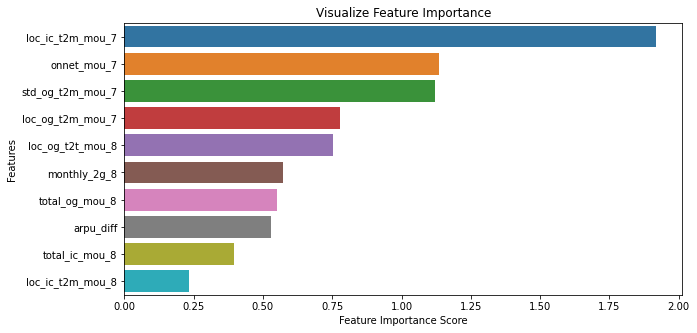

In [ ]:
#Visualize top features.
modlog =pd.DataFrame(odds,X_train_m2_RFE.columns,columns=['Coeff']).sort_values(by="Coeff",ascending=False)

ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=modlog['Coeff'],y=modlog.index)
ax.set_title("Visualize Feature Importance")
ax.set_yticklabels(modlog.index)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.show()
